# 统一数据层
*作者：Sina Kashuk*

### 概述：
六边形的应用之一是能够将具有不同地理形状和形态的不同数据集结合起来。在这个教程中，我们将演示如何将美国人口普查数据、纽约市311噪声投诉数据和数字高程模型带入六边形视口，然后如何可视化数据以获取洞察。

### 数据
* **多边形：** 人口普查轨道数据 [[来源]](https://www.census.gov/data.html)
* **点：** 纽约市311噪声投诉 [[来源]](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/7ahn-ypff)
* **栅格：** 纽约市数字高程模型 [[来源]](https://data.cityofnewyork.us/City-Government/1-foot-Digital-Elevation-Model-DEM-Integer-Raster/7kuu-zah7/)

In [1]:
# modified data link
ct_data_link = 'https://gist.githubusercontent.com/kashuk/e6e3e3d8fde34da1212b59248a7cc5a8/raw/da3b63c1c0ef4a1c8cc8e10f61455c436a0d0ad9/CT_data.csv'
ct_shape_link = 'https://gist.githubusercontent.com/kashuk/d73342adeccbc65de7a53e19ad78b4df/raw/4300dcb80861d454ecae8f8429166e196779fc21/CT_simplified_shape.json'
noise_311_link = 'https://gist.githubusercontent.com/kashuk/670a350ea1f9fc543c3f6916ab392f62/raw/4c5ced45cc94d5b00e3699dd211ad7125ee6c4d3/NYC311_noise.csv'
nyc_dem_link = 'https://gist.githubusercontent.com/kashuk/a08dc8f65b1b1aebafdcab9c0eda3346/raw/4d1cf7a306327f3570ddd6e4979e568ee82c2c71/dem_nyc_encoded.tif'

### 导入和自定义函数

In [2]:
# 导入所需的库
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import shapely
import rtree
import geopandas
import xarray as xr
from geopandas import GeoDataFrame
from shapely.geometry import mapping
from shapely.ops import cascaded_union
import h3
import base64
import urllib
import tempfile
import matplotlib.pyplot as plt
%matplotlib inline

# 定义用于绘制散点图的函数，输入包括数据帧，度量列，x和y坐标列，标记类型，透明度，图形大小和颜色映射。
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

# 定义降采样函数，输入包括数据帧，十六进制列，度量列和粗糙孔径大小，输出是降采样后的数据帧。
def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(lambda x: h3.h3_to_parent(x,coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[[metric_col,]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfc

# 定义环平滑函数，输入包括数据帧，十六进制列，度量列和环数k，输出是平滑后的数据帧。
def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

# 定义加权环平滑函数，输入包括数据帧，十六进制列，度量列和权重系数，输出是加权平滑后的数据帧。
def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]
    
    # weighted smoothing 
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col,inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K=len(coef)-1 
    for k in range(1,K+1):
        temp2.append((df_agg['hexk']
                     .apply(lambda x: pd.Series(list(h3.hex_ring(x,k)))).stack()
                     .to_frame('hexk').reset_index(1, drop=True).reset_index()
                ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x:coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs


# 数据

## 点转化为六边形

### 加载311噪声投诉数据

Text(0.5, 1.0, 'sample points: 311 noise compliants')

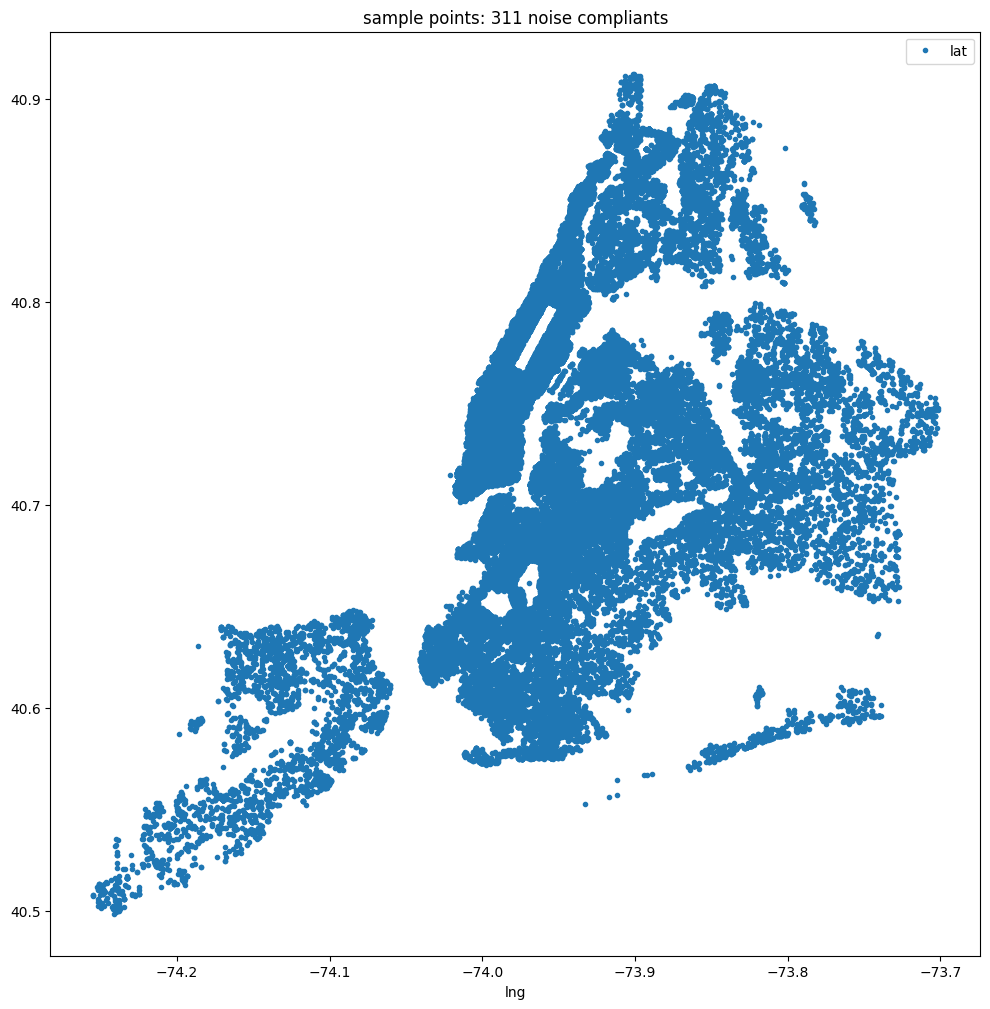

In [3]:
# 加载311噪音投诉数据
df311 = pd.read_csv(noise_311_link)  # 使用pandas的read_csv函数从noise_311_link中读取CSV文件，将其加载到DataFrame df311中

# 可视化311噪音投诉点
df311.plot(x='lng',y='lat',style='.',alpha=1,figsize=(12,12))  # 使用DataFrame的plot方法将噪音投诉点绘制出来，x轴是经度，y轴是纬度，绘制的点以'.'表示，alpha参数表示点的透明度，figsize参数设置图形的大小
plt.title('sample points: 311 noise compliants')  # 使用matplotlib的title函数为图形设置标题，'sample points: 311 noise compliants'表示“样本点：311噪音投诉”


### 转化为h3格网

Text(0.5, 1.0, 'hex-grid: noise complaints')

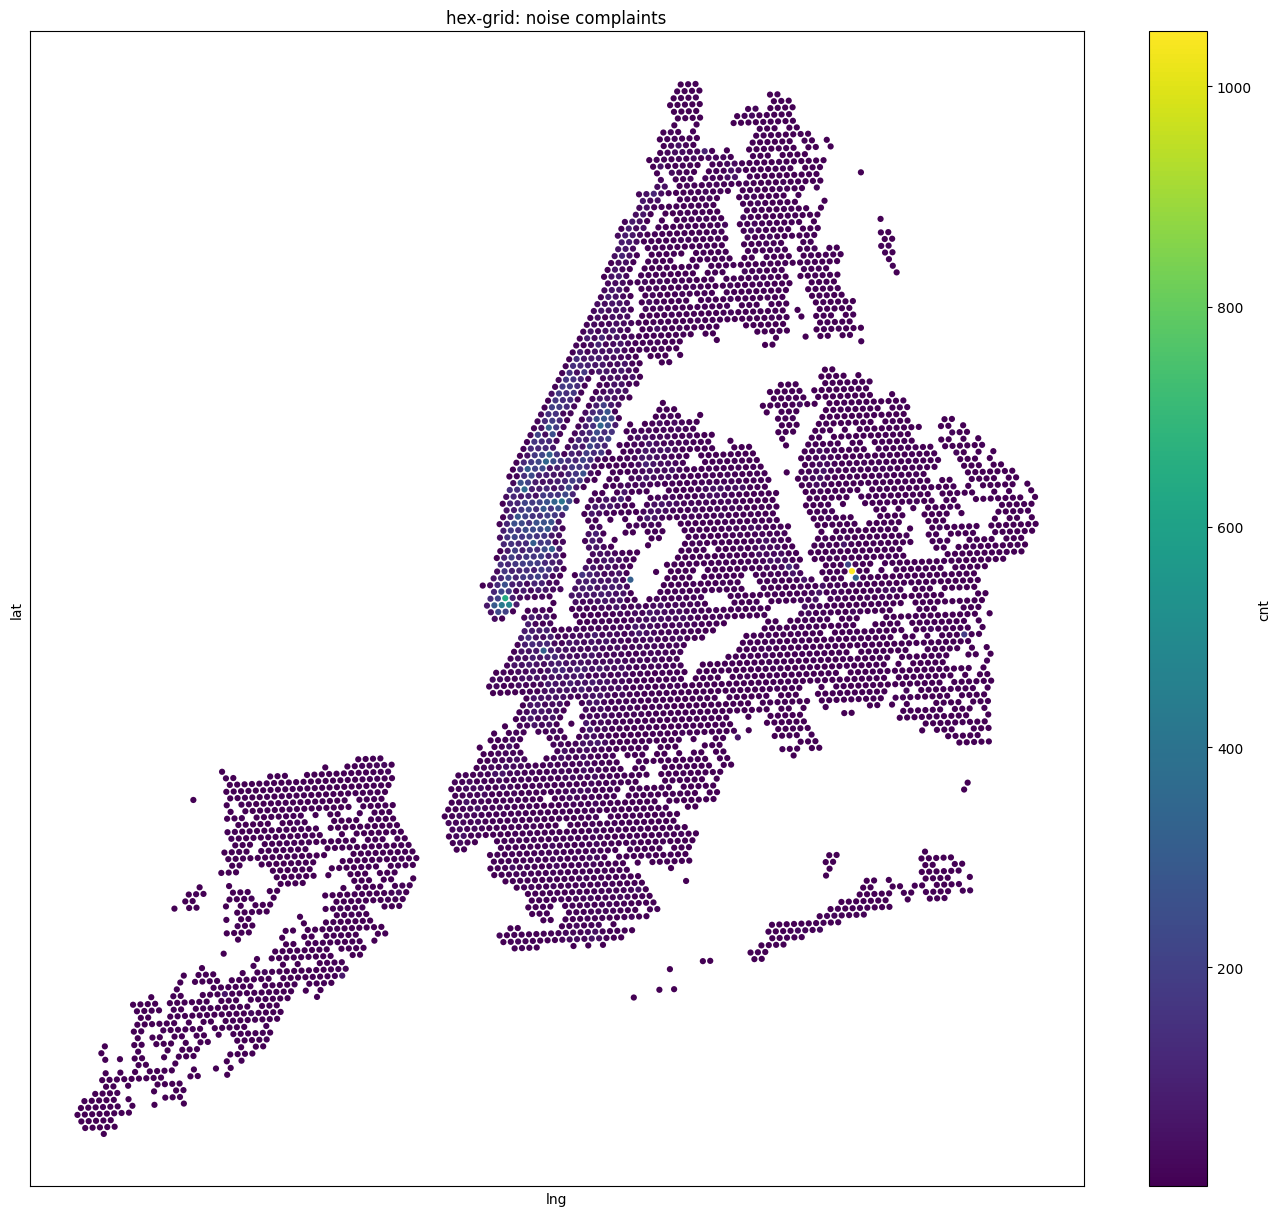

In [4]:
APERTURE_SIZE = 9  # 设置H3六边形网格的精度级别，数字越大，六边形网格的尺寸越小，精度越高
hex_col = 'hex'+str(APERTURE_SIZE)  # 定义一个新的列名称，用于存储每个数据点对应的H3六边形网格的标识

# 找到包含各数据点的H3六边形网格
df311[hex_col] = df311.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)  # 使用H3库的geo_to_h3函数将每个数据点的纬度和经度转化为H3六边形网格的标识，然后将这些标识存储在新的列中

# 聚合各个H3六边形网格中的数据点
df311g = df311.groupby(hex_col).size().to_frame('cnt').reset_index()  # 使用DataFrame的groupby方法按照H3六边形网格标识进行分组，然后使用size方法计算每个组的大小（即每个H3六边形网格中的数据点数量），最后使用reset_index方法重设索引

# 计算各个H3六边形网格的中心点，用于可视化
df311g['lat'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])  # 使用H3库的h3_to_geo函数将每个H3六边形网格的标识转化为纬度和经度，然后将纬度存储在新的列中
df311g['lng'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])  # 同上，将经度存储在新的列中

# 可视化各个H3六边形网格
plot_scatter(df311g, metric_col='cnt', marker='o',figsize=(17,15))  # 使用plot_scatter函数绘制散点图，其中每个点的位置表示H3六边形网格的中心点，点的大小表示该网格中的数据点数量
plt.title('hex-grid: noise complaints')  # 为图形设置标题，'hex-grid: noise complaints'表示“六边形网格：噪音投诉”


### 空间平滑 

sum sanity check: 1.0


Text(0.5, 1.0, 'noise complaints: 2-ring average')

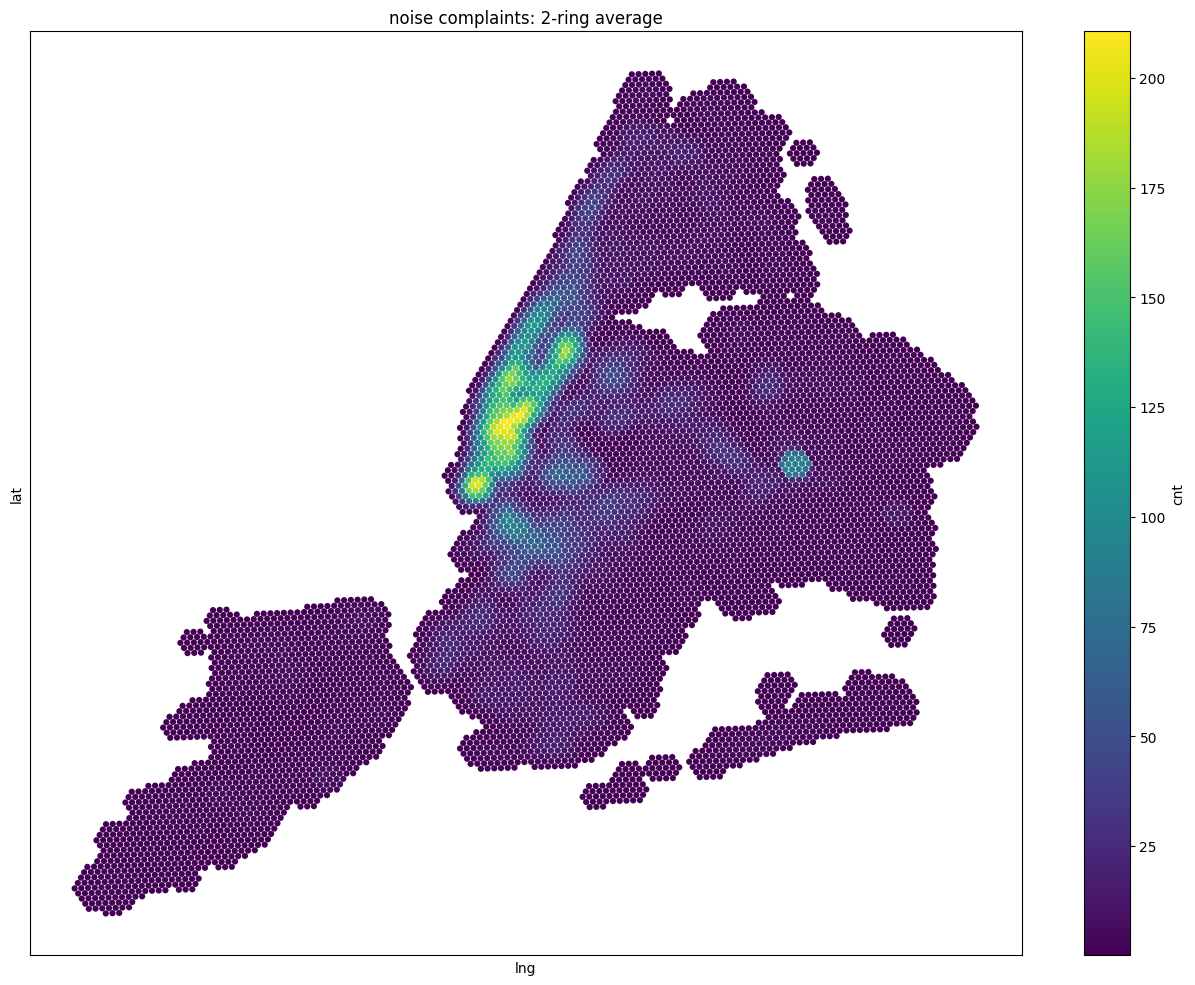

In [5]:
k = 2  # 设置K环的大小，这里K=2，表示使用每个H3六边形网格及其周围两环的网格进行平滑处理

# 进行K环平滑处理
df311s= kring_smoothing(df311g, hex_col, metric_col='cnt', k=k)  # 使用kring_smoothing函数进行K环平滑处理，输入参数包括原始的数据（df311g），H3六边形网格的标识列（hex_col），要进行平滑处理的列（'cnt'，表示每个网格中的数据点数量），以及K环的大小（k）

# 输出平滑处理后的数据点数量与原始数据点数量之比，用于检查数据的完整性
print('sum sanity check:', df311s['cnt'].sum() / df311g['cnt'].sum())  # 使用print函数输出比值，如果比值接近1，说明数据的完整性较好

# 可视化平滑处理后的数据
plot_scatter(df311s, metric_col='cnt', marker='o')  # 使用plot_scatter函数绘制散点图，其中每个点的位置表示H3六边形网格的中心点，点的大小表示经过K环平滑处理后的数据点数量
plt.title('noise complaints: 2-ring average')  # 为图形设置标题，'noise complaints: 2-ring average'表示“噪音投诉：2环平均”


## 矢量数据转化为h3

### 加载数字高程模型数据

In [6]:
# 创建临时目录以处理GeoTiff文件
temp_dir = tempfile.mkdtemp()  # 使用tempfile库的mkdtemp函数创建一个新的临时目录，然后将新目录的路径存储在temp_dir变量中

# 下载并解码GeoTiff数据
open(temp_dir+'nyc_dem.tif', 'wb').write(base64.b64decode(urllib.request.urlopen(nyc_dem_link).read()))  
# 使用urllib库的request.urlopen函数打开给定的URL（nyc_dem_link），然后使用read方法读取URL的内容
# 使用base64库的b64decode函数将读取的内容从Base64格式解码为二进制格式
# 使用open函数以二进制写入模式打开文件（文件路径是新创建的临时目录的路径与文件名的组合），然后使用write方法将解码后的内容写入文件

619768

In [8]:
# 将tif文件转换为XYZ数据框
df = (xr.open_rasterio(temp_dir+'nyc_dem.tif')  # 使用xarray库的open_rasterio函数打开tif文件
      .sel(band=1)  # 选择第一个波段，这通常包含我们需要的地形高度信息
      .to_pandas()  # 将xarray对象转换为pandas数据框
      .stack()  # 将数据框重塑为长格式，即将每个像素的经纬度和海拔高度作为一行
      .reset_index()  # 重置索引，将原来的索引变为列
      .rename(columns={'x': 'lng', 'y': 'lat', 0: 'elevation'}))  # 重命名列名，使其更具有解释性


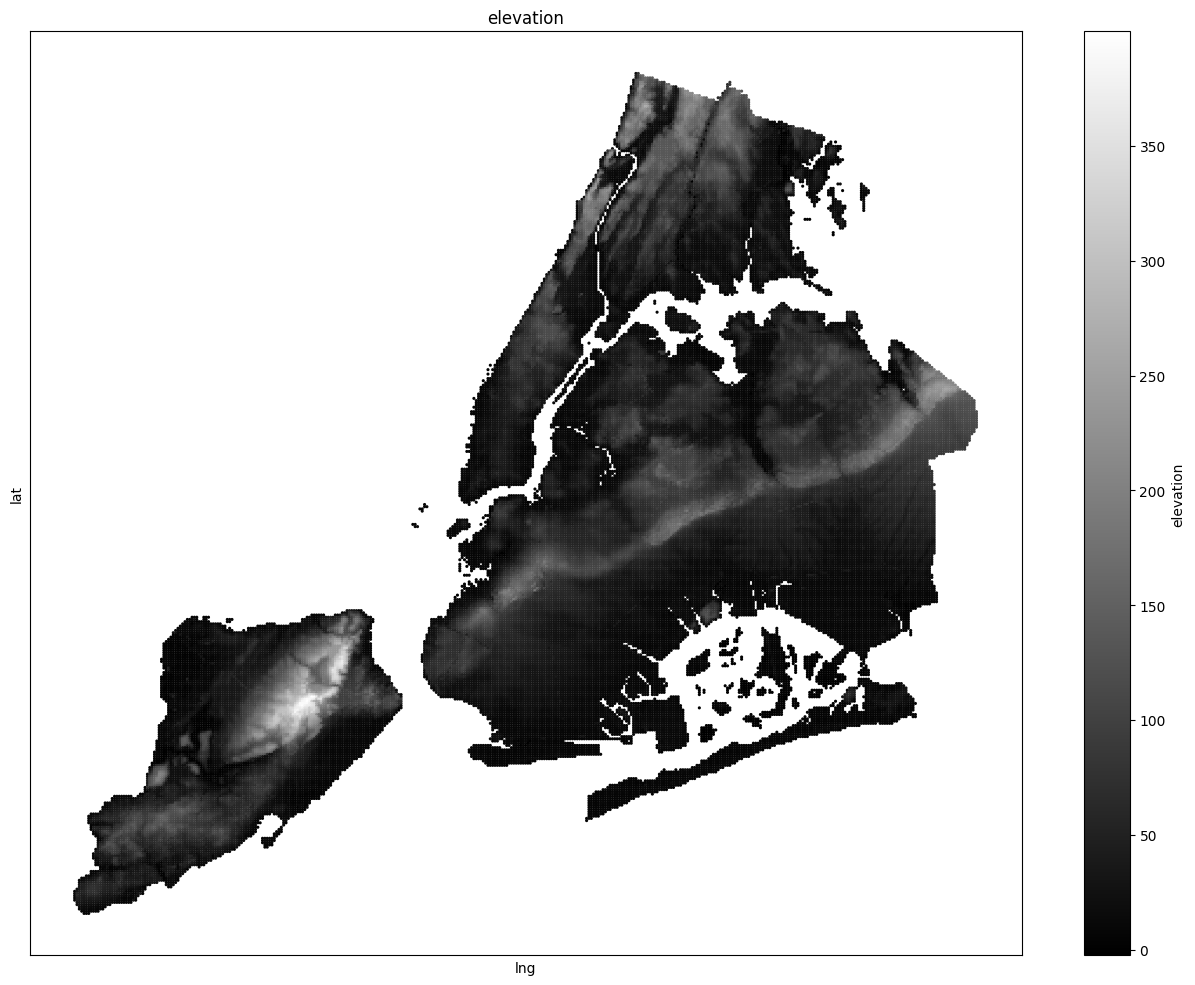

In [9]:
# 忽略缺失值
df = df[df.elevation>-1000]  # 保留海拔高度大于-1000的记录。这是因为在许多地理数据集中，缺失值常常用一个不可能的值（如-9999）来表示。

# 可视化海拔高度
plot_scatter(df, metric_col='elevation', marker='.', colormap='gray')  # 使用自定义的plot_scatter函数绘制散点图，其中每个点的位置表示一个像素的经纬度，颜色表示海拔高度，颜色图为灰度。


> 注：在源文件中，多边形转h3格网这部分内容报错。尝试修bug无果，懂得大佬可以再次尝试，欢迎issue和pr。